# Projeto de Previsão de Aprovação de Empréstimos 🏦

**Análise de Dados e Modelagem Preditiva para Avaliação de Risco de Crédito**

Este notebook tem como objetivo guiar alunos através de um projeto de Machine Learning de ponta a ponta, desde a exploração dos dados até a criação e avaliação de um modelo preditivo para aprovação de empréstimos.

## Seção 0: Introdução ao Projeto

### 0.1. Objetivo do Projeto
O objetivo principal deste projeto é desenvolver um modelo de Machine Learning capaz de prever a probabilidade de aprovação de um pedido de empréstimo (`Loan_Status` = 'Y') ou não (`Loan_Status` = 'N') com base nas características do solicitante e do empréstimo. Utilizaremos um conjunto de dados histórico contendo informações sobre solicitantes e seus empréstimos para treinar um modelo que possa auxiliar na tomada de decisão, minimizando o risco para a instituição financeira e identificando clientes potencialmente elegíveis.

### 0.2. Descrição do Dataset
O dataset (`LoanData.csv`) contém as seguintes features (colunas):

* **Loan_ID:** Identificador único do empréstimo.
* **Gender:** Gênero do solicitante (Male, Female).
* **Married:** Estado civil do solicitante (Yes, No).
* **Dependents:** Número de dependentes do solicitante (0, 1, 2, 3+).
* **Education:** Nível de escolaridade (Graduate, Not Graduate).
* **Self_Employed:** Se o solicitante é autônomo (Yes, No).
* **ApplicantIncome:** Renda do solicitante.
* **CoapplicantIncome:** Renda do co-solicitante.
* **LoanAmount:** Valor do empréstimo (em milhares).
* **Loan_Amount_Term:** Prazo do empréstimo em meses.
* **Credit_History:** Histórico de crédito do solicitante (1: possui histórico bom, 0: não possui).
* **Property_Area:** Área da propriedade (Urban, Semiurban, Rural).
* **Loan_Status (Variável Alvo):** Status da aprovação do empréstimo (Y: Yes, N: No).

Utilizaremos também o arquivo `test.csv` para simular a aplicação do modelo em novos dados, onde o `Loan_Status` é desconhecido.

### 0.3. Métricas de Avaliação
Para avaliar o desempenho do nosso modelo, utilizaremos as seguintes métricas:

* **Acurácia:** Percentual geral de previsões corretas.
* **Matriz de Confusão:** Tabela que visualiza o desempenho do modelo.
* **Precisão (Precision):** Dos que foram previstos como aprovados, quantos realmente foram? (TP / (TP + FP)).
* **Recall (Sensibilidade):** Dos que realmente seriam aprovados, quantos o modelo previu corretamente? (TP / (TP + FN)).
* **F1-Score:** Média harmônica entre Precisão e Recall.
* **Curva ROC e AUC (Area Under the Curve):** Mede a capacidade do modelo de distinguir entre as classes.

### 0.4. Configuração Inicial: Importação de Bibliotecas

In [10]:
# --- Manipulação de Dados ---
import pandas as pd
import numpy as np

# --- Visualização de Dados ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Pré-processamento e Métricas do Scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # Para imputação de valores ausentes

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)

# --- Algoritmos de Machine Learning ---
from sklearn.ensemble import RandomForestClassifier

# --- Para salvar o modelo e o scaler ---
import pickle
import json # Para salvar a lista de colunas (opcional)

# --- Configurações Opcionais ---
plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
RANDOM_STATE = 42 # Semente para reprodutibilidade
np.random.seed(RANDOM_STATE)

## Seção 1: Carregamento e Exploração Inicial dos Dados (EDA)

Nesta seção, carregaremos os dados e realizaremos uma análise exploratória para entender suas características, identificar padrões, valores ausentes e possíveis outliers.

In [11]:
# Carregar o conjunto de dados de treinamento/validação
try:
    df_loan_data = pd.read_csv('LoanData.csv')
except FileNotFoundError:
    print("Arquivo 'LoanData.csv' não encontrado. Verifique o caminho.")
    exit()

# Carregar o conjunto de dados para predição final (test.csv)
try:
    df_test_submission = pd.read_csv('test.csv')
except FileNotFoundError:
    print("Arquivo 'test.csv' não encontrado. Verifique o caminho.")
    exit()

# Exibir as primeiras linhas e informações básicas
print("--- Dados de Treinamento (LoanData.csv) ---")
print("Primeiras 5 linhas:")
display(df_loan_data.head())
print(f"\nDimensões: {df_loan_data.shape[0]} linhas, {df_loan_data.shape[1]} colunas")
print("\nInformações Gerais:")
df_loan_data.info()

print("\n\n--- Dados para Submissão (test.csv) ---")
print("Primeiras 5 linhas:")
display(df_test_submission.head())
print(f"\nDimensões: {df_test_submission.shape[0]} linhas, {df_test_submission.shape[1]} colunas")
print("\nInformações Gerais:")
df_test_submission.info()

--- Dados de Treinamento (LoanData.csv) ---
Primeiras 5 linhas:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y



Dimensões: 614 linhas, 13 colunas

Informações Gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


--- Dados para Submissão (test.csv) ---
Primeiras 5 li

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,0,1,0,0,8.209543,5.857867,191.212521,360.0,1.0,1
1,1,0,0,1,0,8.136811,0.000000,127.000000,360.0,1.0,1
2,1,1,0,1,0,7.664816,7.372746,96.000000,360.0,1.0,1
3,1,1,0,0,0,7.863267,7.438972,107.000000,360.0,1.0,0
4,1,0,0,0,0,7.273786,0.000000,35.000000,360.0,1.0,1



Dimensões: 164 linhas, 11 colunas

Informações Gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             164 non-null    int64  
 1   Married            164 non-null    int64  
 2   Dependents         164 non-null    int64  
 3   Education          164 non-null    int64  
 4   Self_Employed      164 non-null    int64  
 5   ApplicantIncome    164 non-null    float64
 6   CoapplicantIncome  164 non-null    float64
 7   LoanAmount         164 non-null    float64
 8   Loan_Amount_Term   164 non-null    float64
 9   Credit_History     164 non-null    float64
 10  Property_Area      164 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 14.2 KB


### 1.1. Estatísticas Descritivas

In [12]:
print("\n--- Estatísticas Descritivas (Numéricas) - df_loan_data ---")
display(df_loan_data.describe())

print("\n--- Estatísticas Descritivas (Categóricas) - df_loan_data ---")
display(df_loan_data.describe(include=['object', 'category']))


--- Estatísticas Descritivas (Numéricas) - df_loan_data ---


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000



--- Estatísticas Descritivas (Categóricas) - df_loan_data ---


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP002990,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


### 1.2. Verificação de Valores Ausentes (Missing Values)

In [13]:
print("\n--- Valores Ausentes em df_loan_data (%) ---")
missing_percentage_train = (df_loan_data.isnull().sum()[df_loan_data.isnull().sum() > 0] / len(df_loan_data)) * 100
print(missing_percentage_train.sort_values(ascending=False))

print("\n--- Valores Ausentes em df_test_submission (%) ---")
missing_percentage_test = (df_test_submission.isnull().sum()[df_test_submission.isnull().sum() > 0] / len(df_test_submission)) * 100
print(missing_percentage_test.sort_values(ascending=False))


--- Valores Ausentes em df_loan_data (%) ---
Credit_History      8.143322
Self_Employed       5.211726
LoanAmount          3.583062
Dependents          2.442997
Loan_Amount_Term    2.280130
Gender              2.117264
Married             0.488599
dtype: float64

--- Valores Ausentes em df_test_submission (%) ---
Series([], dtype: float64)


**Observação:** As colunas `Credit_History`, `Self_Employed`, `LoanAmount`, `Dependents`, `Gender`, `Loan_Amount_Term` e `Married` possuem valores ausentes e precisarão ser tratadas.

### 1.3. Análise da Variável Alvo (`Loan_Status`)

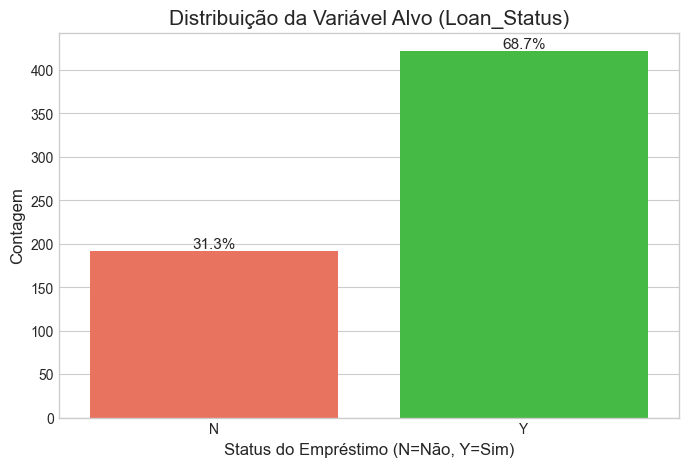

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64


In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Loan_Status', data=df_loan_data, palette=['#FF6347','#32CD32'], order=['N', 'Y'])
plt.title('Distribuição da Variável Alvo (Loan_Status)', fontsize=15)
plt.xlabel('Status do Empréstimo (N=Não, Y=Sim)', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
total = len(df_loan_data['Loan_Status'])
for p in plt.gca().patches:
    percentage = f'{(p.get_height()/total)*100:.1f}%'
    x_coord = p.get_x() + p.get_width() / 2
    y_coord = p.get_height()
    plt.gca().annotate(percentage, (x_coord, y_coord), ha='center', va='bottom', fontsize=11)
plt.show()

print(df_loan_data['Loan_Status'].value_counts(normalize=True))

**Observação:** Observamos um desbalanceamento de classes, com aproximadamente 68.7% dos empréstimos aprovados ('Y') e 31.3% não aprovados ('N'). Isso é importante ao escolher o modelo e as métricas de avaliação.

### 1.4. Análise Univariada (Distribuição das Features)

#### Features Numéricas

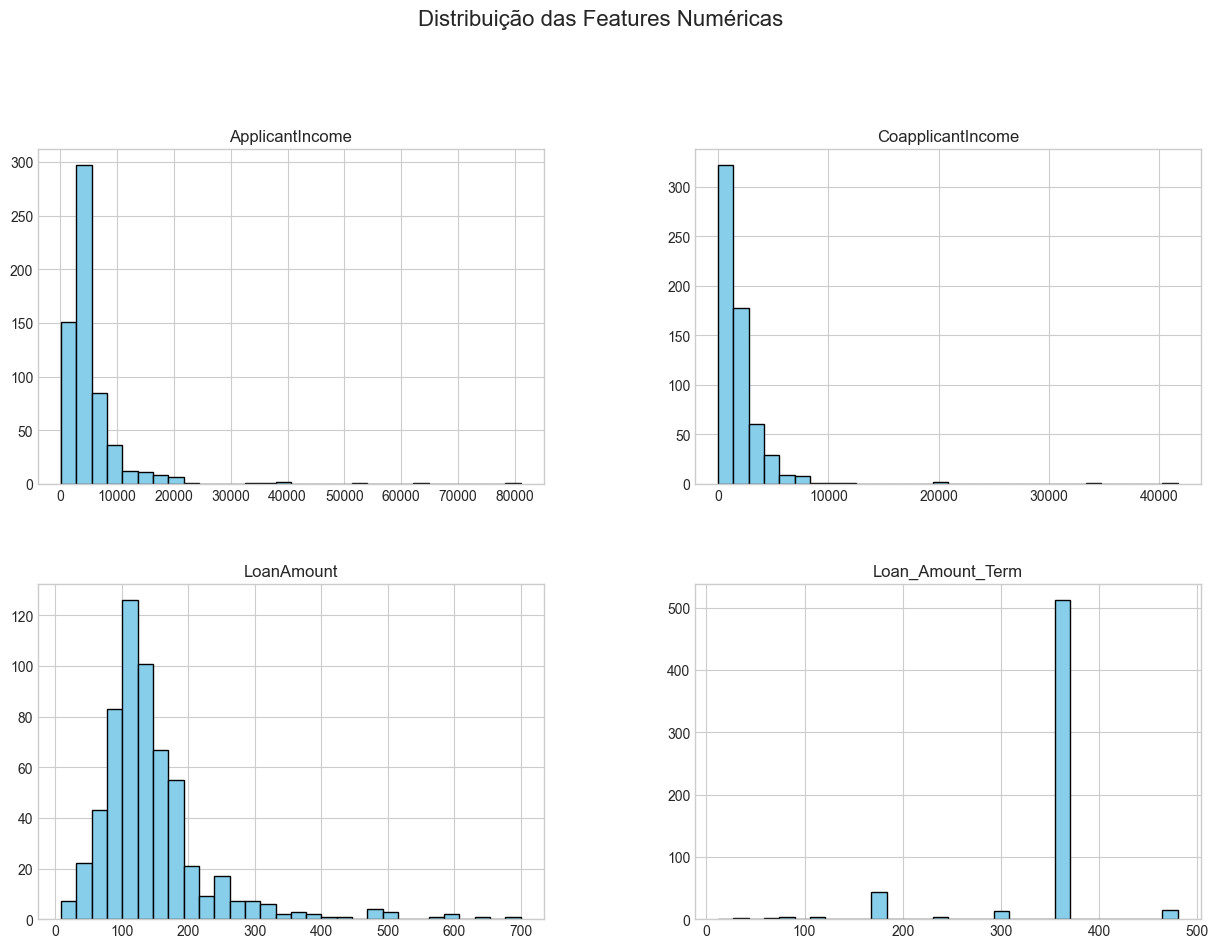

In [15]:
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
df_loan_data[numerical_features].hist(bins=30, figsize=(15, 10), layout=(2, 2), color='skyblue', edgecolor='black')
plt.suptitle('Distribuição das Features Numéricas', fontsize=16, y=1.02)
plt.show()

#### Features Categóricas

Colunas categóricas identificadas para análise na EDA: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


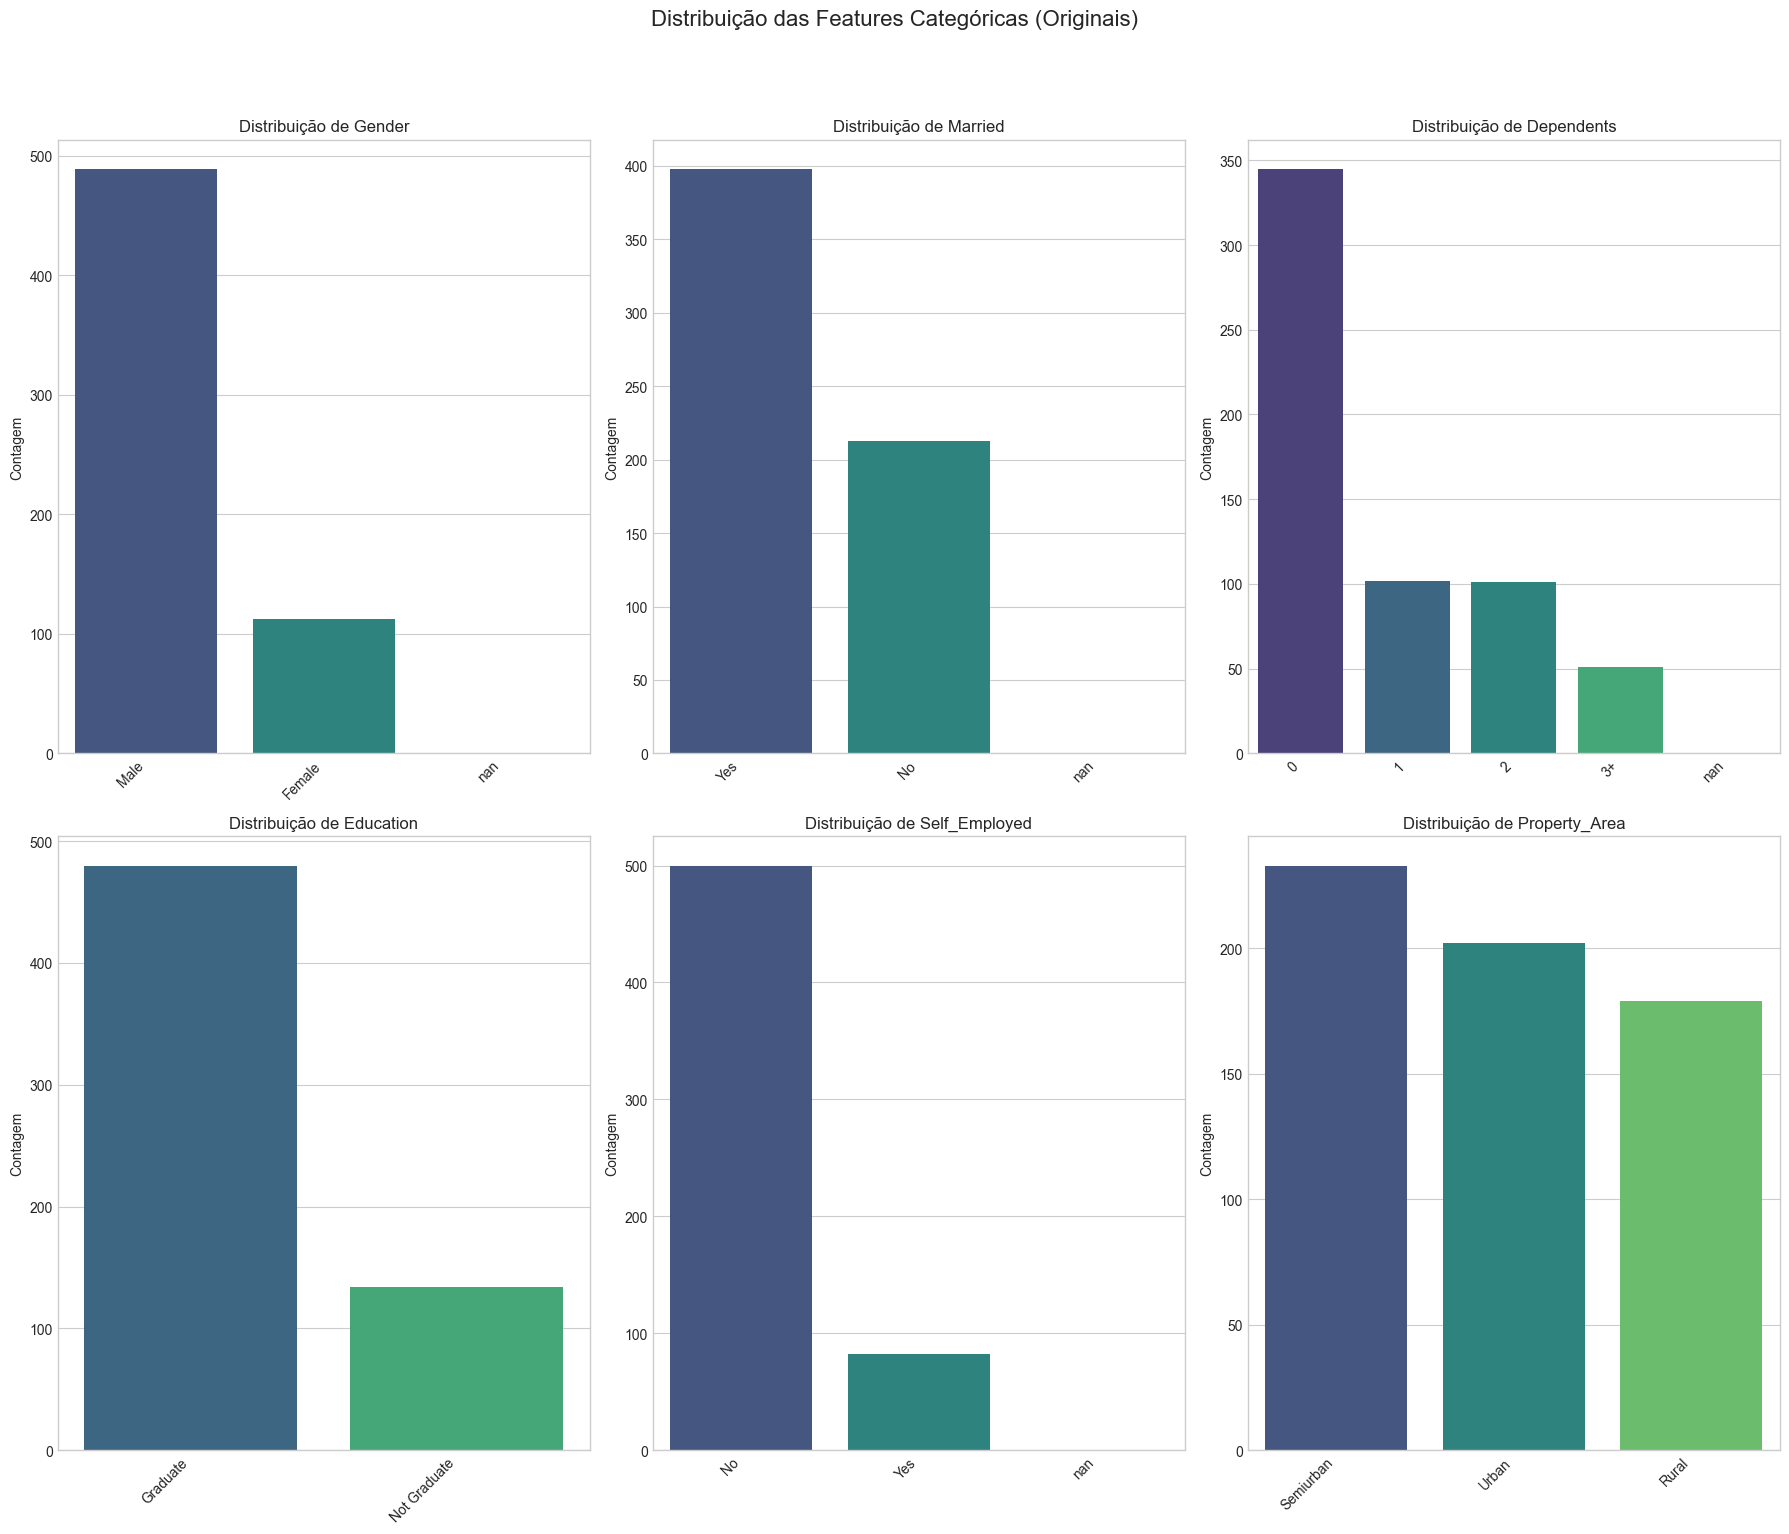

In [18]:
if 'df_loan_data' in locals():
    # Define a lista de colunas categóricas a serem analisadas
    categorical_features = df_loan_data.select_dtypes(include='object').columns.tolist()

    # Remover 'Loan_Status' se estiver presente, pois é o alvo
    if 'Loan_Status' in categorical_features:
        categorical_features.remove('Loan_Status')

    # Remover 'Loan_ID' se ainda estiver presente
    if 'Loan_ID' in categorical_features:
        categorical_features.remove('Loan_ID')

    print(f"Colunas categóricas identificadas para análise na EDA: {categorical_features}")

    if categorical_features: # Prosseguir somente se a lista não estiver vazia
        plt.figure(figsize=(18, 15))
        # Ajustar o layout do subplot dinamicamente
        num_cols_subplot = 3
        num_rows_subplot = (len(categorical_features) + num_cols_subplot - 1) // num_cols_subplot

        for i, col in enumerate(categorical_features):
            plt.subplot(num_rows_subplot, num_cols_subplot, i + 1)
            # Verificar se a coluna existe antes de tentar plotar
            if col in df_loan_data.columns:
                sns.countplot(x=col, data=df_loan_data, palette='viridis', order=df_loan_data[col].value_counts(dropna=False).index)
                plt.title(f'Distribuição de {col}', fontsize=12)
                plt.xlabel('')
                plt.ylabel('Contagem')
                plt.xticks(rotation=45, ha='right')
            else:
                plt.title(f'Coluna {col} não encontrada', fontsize=12)
        
        plt.suptitle('Distribuição das Features Categóricas (Originais)', fontsize=16, y=1.02)
        plt.tight_layout(rect=[0,0,1,0.98])
        plt.show()
    else:
        print("Nenhuma coluna categórica (tipo object) encontrada para plotagem univariada, além de Loan_Status/Loan_ID.")
else:
    print("DataFrame df_loan_data não foi carregado.")

**Observação:** `ApplicantIncome`, `CoapplicantIncome` e `LoanAmount` são assimétricas à direita (positive skew), indicando a presença de valores mais altos que concentram a cauda da distribuição. `Loan_Amount_Term` é mais discreta, com concentrações em certos prazos (ex: 360 meses).

### 1.5. Análise de Outliers (Features Numéricas)

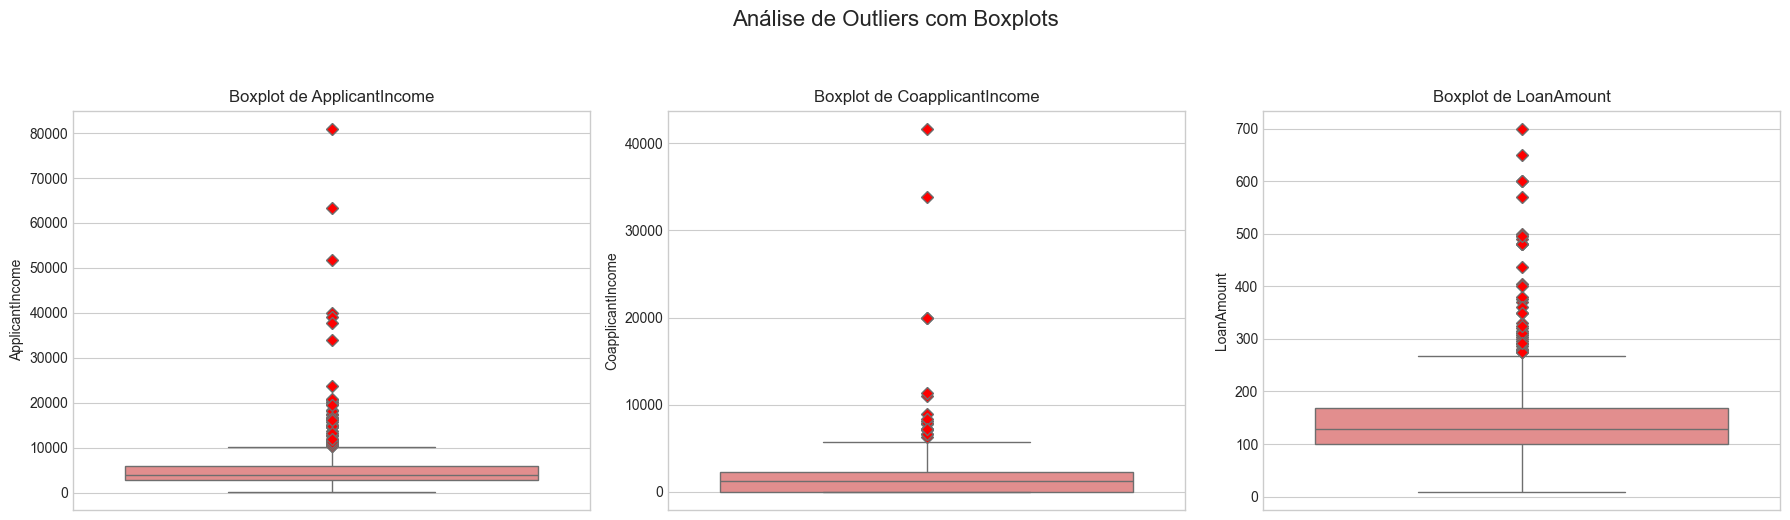

In [19]:
plt.figure(figsize=(18, 5))
numerical_to_check_outliers = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

for i, col in enumerate(numerical_to_check_outliers):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df_loan_data[col], color='lightcoral', flierprops=dict(markerfacecolor='r', marker='D'))
    plt.title(f'Boxplot de {col}', fontsize=12)
    plt.ylabel(col)
plt.suptitle('Análise de Outliers com Boxplots', fontsize=16, y=1.03)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

**Observação:** As features `ApplicantIncome`, `CoapplicantIncome` e `LoanAmount` mostram outliers, especialmente na cauda superior.
* **Contexto dos Outliers:** Em dados de renda e empréstimo, valores muito altos podem ser legítimos (clientes de alta renda, grandes empréstimos) e não necessariamente erros.
* **Impacto:** Outliers podem distorcer a escala das features e influenciar modelos sensíveis a eles (como Regressão Logística ou SVM). Modelos baseados em árvores (como Random Forest, que usaremos) são geralmente mais robustos.
* **Tratamento:** Abordaremos isso no pré-processamento através da **transformação logarítmica**, que ajuda a reduzir a assimetria e o impacto desses valores extremos. Outras técnicas como *capping* (winsorização) poderiam ser usadas, mas a transformação logarítmica é uma boa primeira abordagem aqui.

### 1.6. Análise Bivariada (Relação das Features com `Loan_Status`)

#### Features Categóricas vs. `Loan_Status`

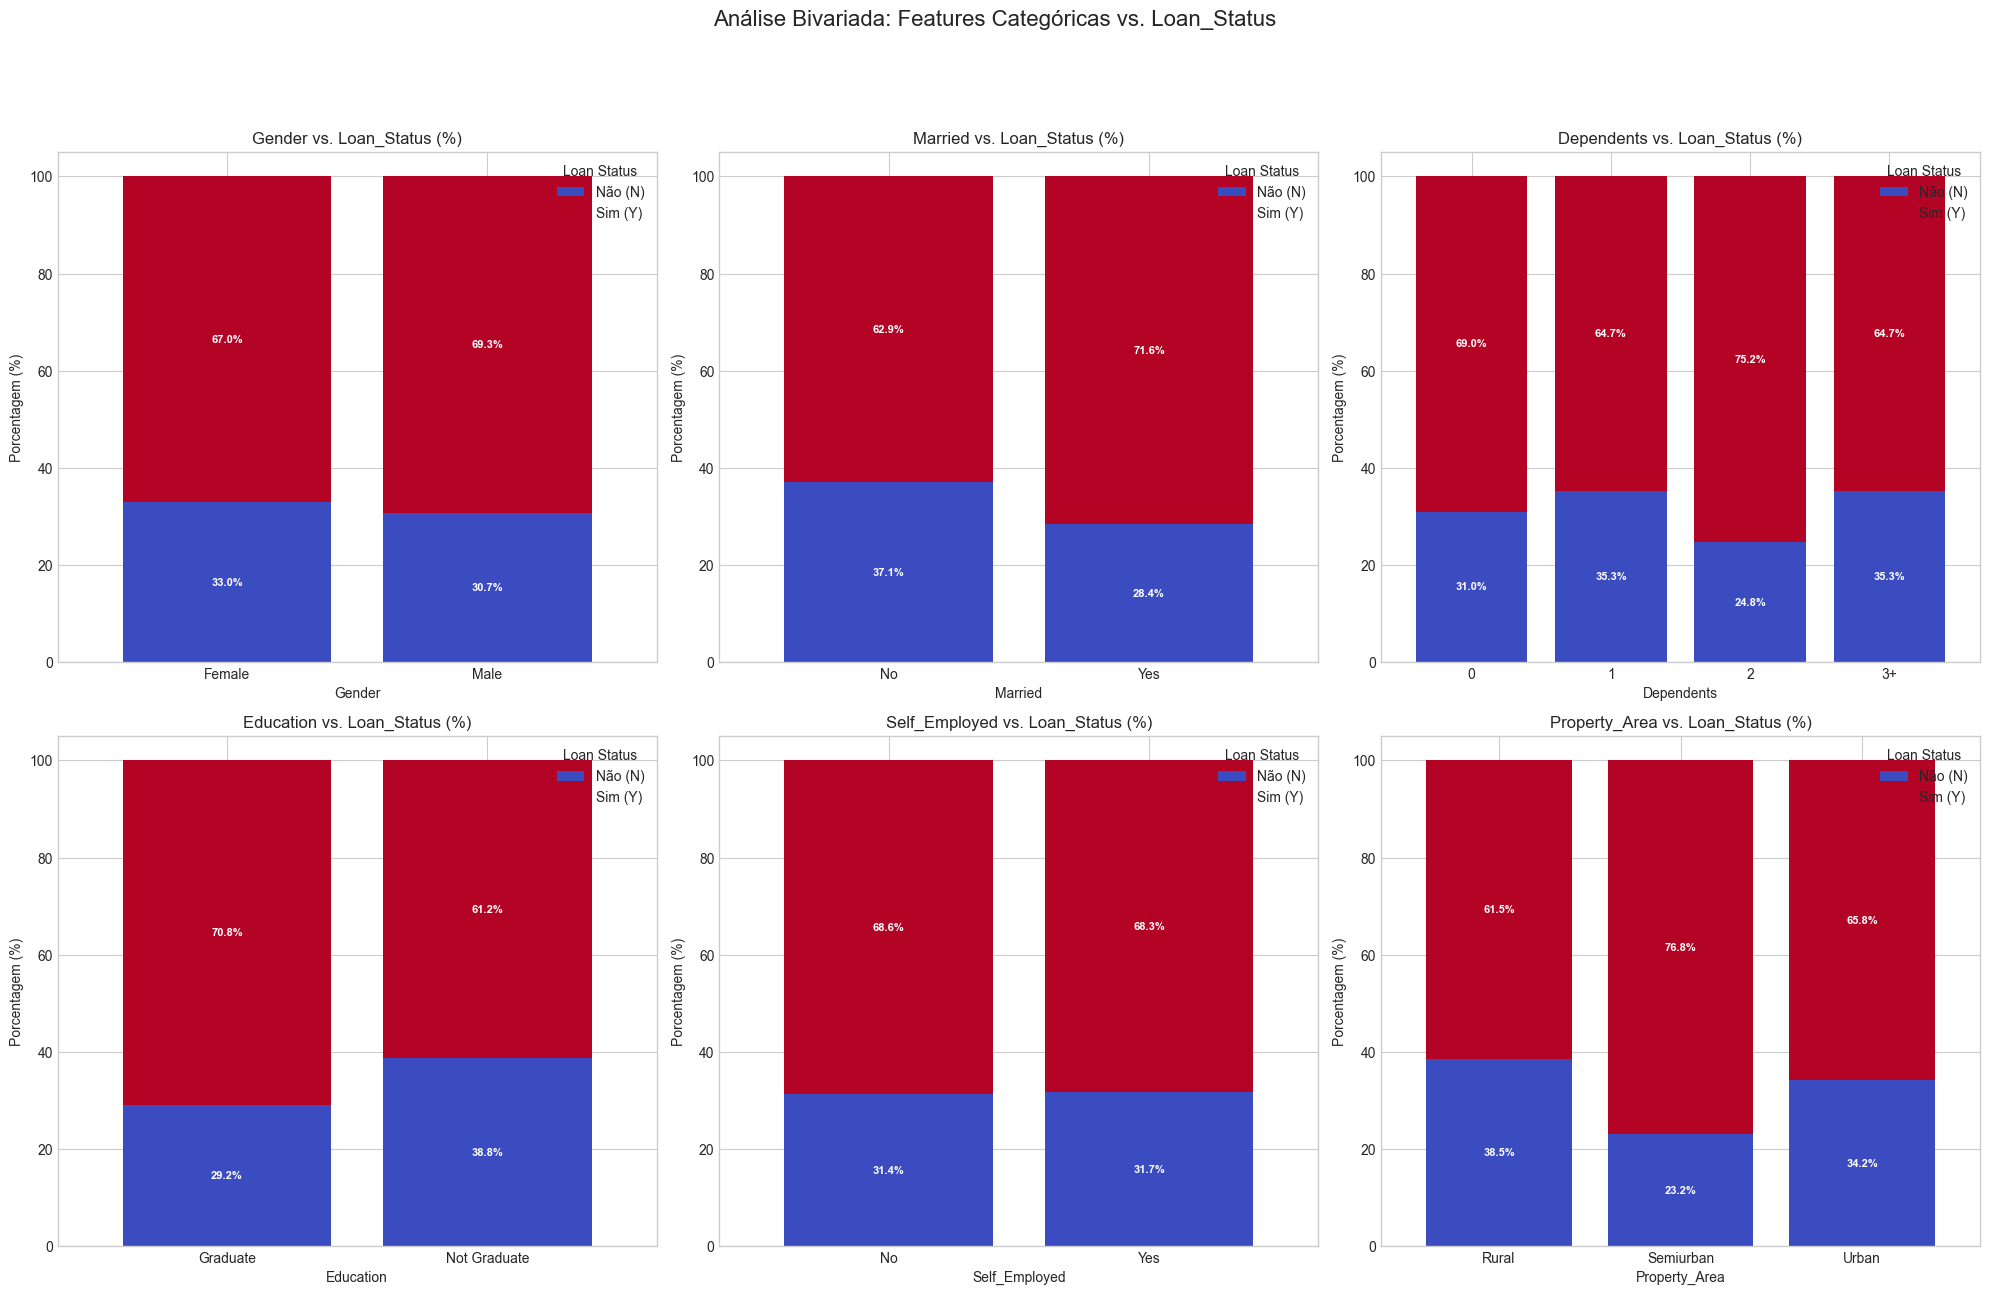

In [20]:
plt.figure(figsize=(20, 18))
for i, col in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)
    contingency_table = pd.crosstab(df_loan_data[col], df_loan_data['Loan_Status'], normalize='index')*100
    ax = contingency_table.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='coolwarm', width=0.8)
    plt.title(f'{col} vs. Loan_Status (%)', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Porcentagem (%)', fontsize=10)
    plt.xticks(rotation=0)
    plt.legend(title='Loan Status', labels=['Não (N)', 'Sim (Y)'])
    # Adicionar anotações de porcentagem
    for c in ax.containers:
        labels = [f'{w:.1f}%' if w > 0 else '' for w in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=8, color='white', fontweight='bold')

plt.suptitle('Análise Bivariada: Features Categóricas vs. Loan_Status', fontsize=16, y=1.02)
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()

**Observações:**
* `Credit_History`: Ter histórico de crédito (1.0) está fortemente associado a uma maior taxa de aprovação.
* `Married`: Pessoas casadas parecem ter uma taxa de aprovação ligeiramente maior.
* `Property_Area`: A área 'Semiurban' apresenta a maior taxa de aprovação.

#### Features Numéricas vs. `Loan_Status`

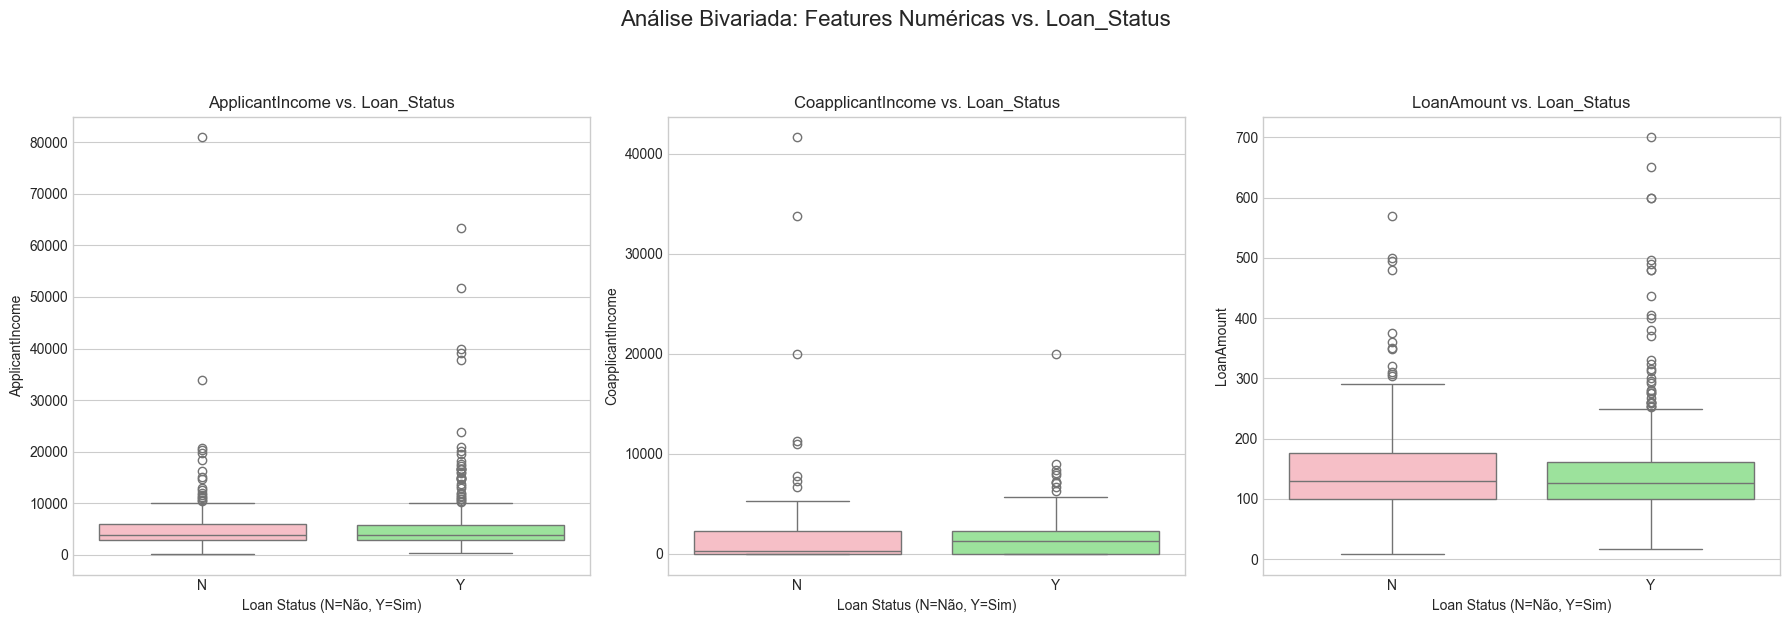

In [21]:
plt.figure(figsize=(18, 6))
for i, col in enumerate(numerical_to_check_outliers): # Usando as mesmas de outliers
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='Loan_Status', y=col, data=df_loan_data, palette=['#FFB6C1','#90EE90'], order=['N', 'Y'])
    plt.title(f'{col} vs. Loan_Status', fontsize=12)
    plt.xlabel('Loan Status (N=Não, Y=Sim)')
    plt.ylabel(col)
plt.suptitle('Análise Bivariada: Features Numéricas vs. Loan_Status', fontsize=16, y=1.03)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

### 1.7. Mapa de Correlação (Features Numéricas)

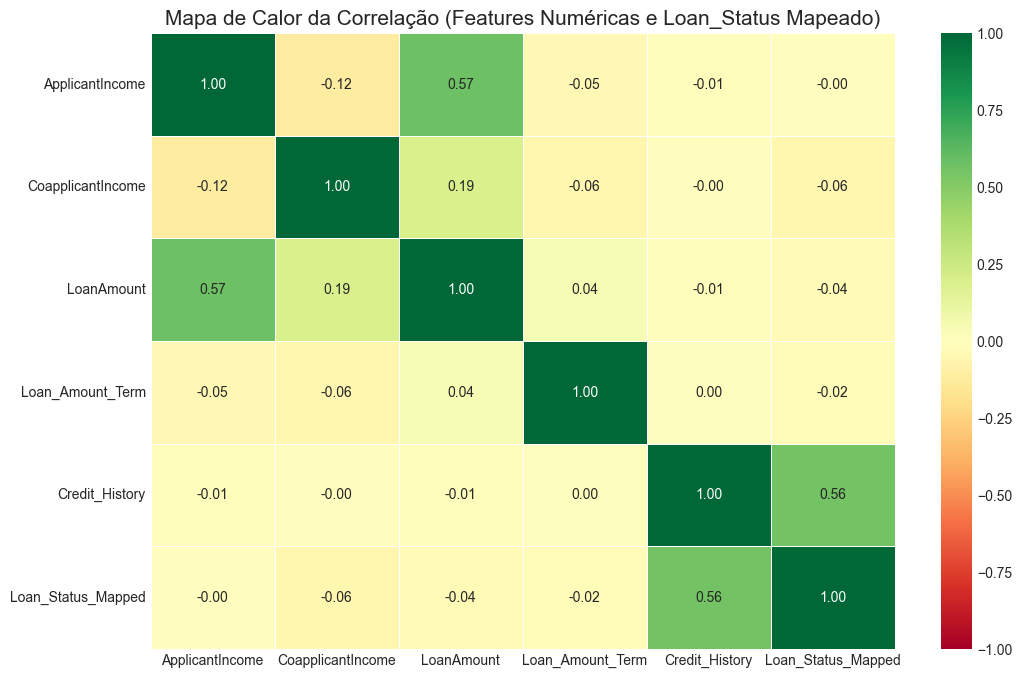

In [22]:
temp_df_corr = df_loan_data.copy()
temp_df_corr['Loan_Status_Mapped'] = temp_df_corr['Loan_Status'].map({'Y': 1, 'N': 0})
# Selecionar apenas colunas numéricas para o cálculo da correlação
numerical_cols_for_corr = temp_df_corr.select_dtypes(include=np.number).columns

plt.figure(figsize=(12, 8))
sns.heatmap(temp_df_corr[numerical_cols_for_corr].corr(), annot=True, cmap='RdYlGn', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Mapa de Calor da Correlação (Features Numéricas e Loan_Status Mapeado)', fontsize=15)
plt.show()

**Observação:** `Credit_History` apresenta a correlação positiva mais significativa com `Loan_Status_Mapped`. `LoanAmount` tem uma leve correlação positiva com `ApplicantIncome`.

## Seção 2: Pré-processamento dos Dados

Nesta seção, preparamos os dados para a modelagem. Isso inclui:
1.  Divisão em treino e validação.
2.  Criação de novas features (Engenharia de Features).
3.  Transformações logarítmicas para lidar com assimetria/outliers.
4.  Imputação de valores ausentes.
5.  Codificação de features categóricas.
6.  Escalonamento de features numéricas.

**Princípio Fundamental:** Todas as transformações que "aprendem" dos dados (cálculo de medianas, modas, ajuste de scalers) devem ser feitas **APENAS no conjunto de TREINO**. Essas transformações aprendidas são então aplicadas de forma consistente aos conjuntos de treino, validação e submissão (`test.csv`).

### 2.1. Divisão dos Dados em Treino e Validação

In [23]:
# Guardar Loan_ID de df_test_submission para o arquivo de submissão final
# Como 'Loan_ID' não existe em df_test_submission, submission_loan_ids será None.
submission_loan_ids = df_test_submission['Loan_ID'].copy() if 'Loan_ID' in df_test_submission.columns else None
if submission_loan_ids is None:
    print("Aviso: Coluna 'Loan_ID' não encontrada em df_test_submission. Não será possível usar IDs para submissão.")

# Remover Loan_ID de df_loan_data (assumindo que existe aqui)
if 'Loan_ID' in df_loan_data.columns:
    df_loan_data_processed = df_loan_data.drop('Loan_ID', axis=1)
else:
    print("Aviso: Coluna 'Loan_ID' não encontrada em df_loan_data.")
    df_loan_data_processed = df_loan_data.copy() # Apenas copia se não existir

# Para df_test_submission, como 'Loan_ID' não existe, apenas copiamos ou usamos errors='ignore'.
# Usar errors='ignore' é seguro e garante que se, por acaso, em outro CSV ela existir, será removida.
df_test_submission_processed = df_test_submission.drop('Loan_ID', axis=1, errors='ignore')


# Separar features (X) e variável alvo (y) do df_loan_data_processed
X = df_loan_data_processed.drop('Loan_Status', axis=1)
y = df_loan_data_processed['Loan_Status'].copy()

# O conjunto de teste para submissão (sem Loan_Status)
X_submission = df_test_submission_processed.copy()

# Dividir X e y em conjuntos de treinamento e validação (80% treino, 20% validação)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

print(f"\nDimensões de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Dimensões de X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Dimensões de X_submission: {X_submission.shape}")

# Fazer cópias explícitas para evitar SettingWithCopyWarning durante as transformações subsequentes
X_train = X_train.copy()
X_val = X_val.copy()
X_submission = X_submission.copy()

Aviso: Coluna 'Loan_ID' não encontrada em df_test_submission. Não será possível usar IDs para submissão.

Dimensões de X_train: (491, 11), y_train: (491,)
Dimensões de X_val: (123, 11), y_val: (123,)
Dimensões de X_submission: (164, 11)


### 2.2. Engenharia de Features: `TotalIncome`
Criaremos uma nova feature `TotalIncome` somando `ApplicantIncome` e `CoapplicantIncome`. Em seguida, removeremos as colunas originais de renda individual.

In [24]:
for df in [X_train, X_val, X_submission]:
    df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df.drop(['ApplicantIncome', 'CoapplicantIncome'], axis=1, inplace=True)

print("--- X_train após criação de 'TotalIncome' e remoção das originais (exemplo) ---")
display(X_train[['TotalIncome']].head())

--- X_train após criação de 'TotalIncome' e remoção das originais (exemplo) ---


,TotalIncome
154,3254.0
239,3315.0
448,5050.0
471,4153.0
273,4843.0


### 2.3. Transformações Logarítmicas (Assimetria e Outliers)
Aplicaremos a transformação `log(1+x)` em `TotalIncome` (nova feature) e `LoanAmount` para reduzir a assimetria e o impacto de outliers.

--- X_train após transformação logarítmica (exemplo) ---


,TotalIncome,LoanAmount
154,8.087948,3.931826
239,8.106515,4.574711
448,8.527342,5.017280
471,8.331827,4.736198
273,8.485496,5.017280


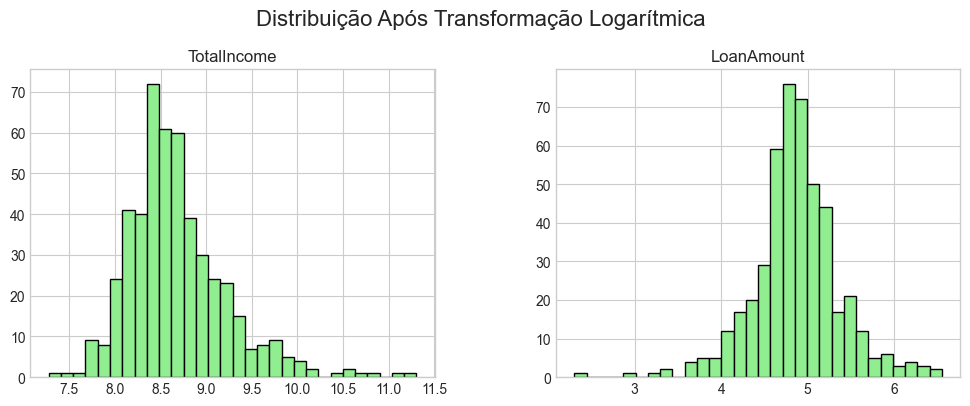

In [25]:
log_transform_cols = ['TotalIncome', 'LoanAmount']

for df in [X_train, X_val, X_submission]:
    for col in log_transform_cols:
        if col in df.columns: # Verificar se a coluna existe
             df[col] = np.log1p(df[col].astype(float)) # Garantir que é float antes do log

print("--- X_train após transformação logarítmica (exemplo) ---")
display(X_train[log_transform_cols].head())

# # Visualizar o efeito da transformação (opcional)
X_train[log_transform_cols].hist(bins=30, figsize=(12, 4), layout=(1, 2), color='lightgreen', edgecolor='black')
plt.suptitle('Distribuição Após Transformação Logarítmica', fontsize=16, y=1.03)
plt.show()

### 2.4. Imputação de Valores Ausentes
Usaremos `SimpleImputer`: mediana para numéricas e moda para categóricas, aprendidas em `X_train`.

In [26]:

# X_train, X_val, X_submission já foram copiados e tiveram a engenharia de features (TotalIncome) aplicada.

# Identificar colunas numéricas e categóricas restantes em X_train ATUAL
# É importante que esta seleção seja feita nos DataFrames que já passaram pela Seção 2.2 e 2.3
numerical_cols_impute = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols_impute = X_train.select_dtypes(include='object').columns.tolist()

print(f"Colunas numéricas para imputar em X_train: {numerical_cols_impute}")
print(f"Colunas categóricas para imputar em X_train: {categorical_cols_impute}")

# Imputadores
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

# --- Aplicar Imputação ---

# X_train (fit_transform)
if numerical_cols_impute:
    X_train[numerical_cols_impute] = median_imputer.fit_transform(X_train[numerical_cols_impute])
if categorical_cols_impute:
    X_train[categorical_cols_impute] = mode_imputer.fit_transform(X_train[categorical_cols_impute])

# X_val (transform)
# Garantir que estamos transformando as mesmas colunas com base no que foi aprendido em X_train
# e que essas colunas existem em X_val.
val_numerical_to_impute = [col for col in numerical_cols_impute if col in X_val.columns]
val_categorical_to_impute = [col for col in categorical_cols_impute if col in X_val.columns]

if val_numerical_to_impute:
    X_val[val_numerical_to_impute] = median_imputer.transform(X_val[val_numerical_to_impute])
if val_categorical_to_impute:
    X_val[val_categorical_to_impute] = mode_imputer.transform(X_val[val_categorical_to_impute])

# X_submission (transform)
submission_numerical_to_impute = [col for col in numerical_cols_impute if col in X_submission.columns]
submission_categorical_to_impute = [col for col in categorical_cols_impute if col in X_submission.columns]

if submission_numerical_to_impute:
    X_submission[submission_numerical_to_impute] = median_imputer.transform(X_submission[submission_numerical_to_impute])
if submission_categorical_to_impute:
    X_submission[submission_categorical_to_impute] = mode_imputer.transform(X_submission[submission_categorical_to_impute])


# --- VERIFICAÇÃO APÓS IMPUTAÇÃO (MANTENHA ESTA PARTE EXATAMENTE COMO ESTÁ ABAIXO) ---
print("\n--- Valores Únicos em Colunas Categóricas de X_train APÓS IMPUTAÇÃO (REVISADA) ---")
# Lista das colunas que DEVEM ser categóricas (tipo object) após esta etapa, antes do mapeamento
# (Dependents será tratada separadamente para se tornar numérica)
cols_to_check_unique_after_impute = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

for col in cols_to_check_unique_after_impute:
    if col in X_train.columns:
        print(f"\nValores únicos na coluna '{col}' de X_train:")
        print(X_train[col].unique()) # Deve mostrar ex: ['Male', 'Female']
        print(f"Contagem de valores na coluna '{col}' de X_train:")
        print(X_train[col].value_counts(dropna=False))
    else:
        print(f"Aviso: Coluna '{col}' não encontrada em X_train para verificação de valores únicos.")

print("\n--- Tipos de Dados em X_train (APÓS IMPUTAÇÃO REVISADA) ---")
X_train.info() # Verifique se Gender, Married etc. são 'object' e se TotalIncome existe e não está vazia.
               # ApplicantIncome e CoapplicantIncome não devem mais existir.

Colunas numéricas para imputar em X_train: ['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome']
Colunas categóricas para imputar em X_train: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

--- Valores Únicos em Colunas Categóricas de X_train APÓS IMPUTAÇÃO (REVISADA) ---

Valores únicos na coluna 'Gender' de X_train:
['Male' 'Female']
Contagem de valores na coluna 'Gender' de X_train:
Gender
Male      404
Female     87
Name: count, dtype: int64

Valores únicos na coluna 'Married' de X_train:
['No' 'Yes']
Contagem de valores na coluna 'Married' de X_train:
Married
Yes    322
No     169
Name: count, dtype: int64

Valores únicos na coluna 'Education' de X_train:
['Graduate' 'Not Graduate']
Contagem de valores na coluna 'Education' de X_train:
Education
Graduate        380
Not Graduate    111
Name: count, dtype: int64

Valores únicos na coluna 'Self_Employed' de X_train:
['No' 'Yes']
Contagem de valores na coluna 'Self_Employed' de X_train

### 2.5. Codificação de Features Categóricas

In [27]:

# `Dependents` (já foi imputado, agora converter para numérico)
for df in [X_train, X_val, X_submission]:
    if 'Dependents' in df.columns:
        # Primeiro, garantir que a imputação da moda de 'Dependents' aconteceu e é string
        # Se SimpleImputer foi usado com DataFrames, as colunas já devem estar preenchidas.
        # Esta conversão é para garantir que '3+' seja tratado.
        df['Dependents'] = df['Dependents'].astype(str).replace('3+', '3')
        df['Dependents'] = pd.to_numeric(df['Dependents'])
        # Se, por algum motivo, pd.to_numeric introduzir NaN (ex: valor não numérico inesperado),
        # preencher com a moda de X_train. (Isso é uma segurança extra).
        if df['Dependents'].isnull().any():
            dependents_train_mode = X_train['Dependents'].mode()[0] # Moda de X_train já processado
            df['Dependents'].fillna(dependents_train_mode, inplace=True)
        df['Dependents'] = df['Dependents'].astype(int)


# Mapeamento Manual para Outras Categóricas
gender_map = {'Male': 1, 'Female': 0}
married_map = {'Yes': 1, 'No': 0}
education_map = {'Graduate': 1, 'Not Graduate': 0}
self_employed_map = {'Yes': 1, 'No': 0}
property_area_map = {'Urban': 2, 'Semiurban': 1, 'Rural': 0}

# Lista de tuplas: (nome_coluna, mapa_a_usar)
mappings_to_apply = [
    ('Gender', gender_map),
    ('Married', married_map),
    ('Education', education_map),
    ('Self_Employed', self_employed_map),
    ('Property_Area', property_area_map)
]

for df in [X_train, X_val, X_submission]:
    for col, current_map in mappings_to_apply:
        if col in df.columns:
            # Aplicar o mapeamento
            df[col] = df[col].map(current_map)

            # TRATAMENTO DE NaNs INTRODUZIDOS PELO .map()
            # Se algum valor original não estava no mapa, .map() introduz NaN.
            # Vamos preencher esses NaNs com a moda da coluna DE TREINAMENTO (X_train) após o mapeamento.
            # Isso requer que X_train seja processado primeiro e suas modas pós-mapeamento sejam conhecidas.

            # Para simplificar e garantir robustez, vamos preencher NaNs aqui
            # com um valor que não cause erro, ou recalcular a moda se necessário.
            # Uma abordagem mais segura é garantir que a imputação anterior (com SimpleImputer)
            # já tenha preenchido todos os valores categóricos com as categorias esperadas.

            # Se após o .map(), ainda houver NaNs, significa que a imputação de moda
            # na etapa anterior não foi suficiente ou os valores mapeados não cobriram tudo.
            # A melhor prática é garantir que a imputação anterior (2.4) já tenha preenchido
            # as colunas categóricas com os valores mais frequentes ('Male', 'Female', 'Yes', 'No' etc.).
            # Se o SimpleImputer foi usado corretamente em colunas 'object', ele deve ter preenchido
            # os NaNs com 'Male'/'Female' etc., então o .map() não deveria gerar NaNs.

            # Verificação e preenchimento de NaNs ANTES do .astype(int)
            if df[col].isnull().any():
                # Calcular a moda da coluna específica em X_train *após* o mapeamento,
                # mas antes do .astype(int), para preencher NaNs em X_val e X_submission.
                # Isso é um pouco mais complexo de gerenciar aqui no loop.

                # Uma solução mais simples é preencher com um valor padrão (ex: -1 ou a moda numérica)
                # ou garantir que a imputação anterior foi perfeita.
                # Vamos assumir que a imputação anterior deveria ter tratado isso.
                # Se ainda há NaNs, é um sinal de que a etapa de imputação precisa ser revisada
                # para garantir que as colunas categóricas só contenham valores mapeáveis.

                # Para este ponto, se um NaN surgir do .map(), isso indica um valor na coluna original
                # que não é nem 'Male' nem 'Female' (para Gender, por exemplo) e que
                # não foi tratado pela imputação de moda anterior.
                # Preenchendo com -1 como placeholder para evitar o erro de .astype(int),
                # mas o ideal é que não haja NaNs aqui.
                print(f"Aviso: NaNs encontrados na coluna '{col}' do DataFrame após o mapeamento. Isso indica valores não mapeados. Preenchendo com 0 para evitar erro de .astype(int). Revise a imputação ou os valores originais.")
                df[col].fillna(0, inplace=True) # Ou outra estratégia, como a moda da coluna numérica

            # Converter para inteiro
            df[col] = df[col].astype(int)


print("\n--- X_train após codificação categórica (exemplo) ---")
# Certifique-se que as colunas existem antes de tentar acessá-las para o display
cols_for_display = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
existing_cols_for_display = [col for col in cols_for_display if col in X_train.columns]
if existing_cols_for_display:
    display(X_train[existing_cols_for_display].head())
else:
    print("Nenhuma das colunas de display especificadas existe em X_train.")

Aviso: NaNs encontrados na coluna 'Gender' do DataFrame após o mapeamento. Isso indica valores não mapeados. Preenchendo com 0 para evitar erro de .astype(int). Revise a imputação ou os valores originais.
Aviso: NaNs encontrados na coluna 'Married' do DataFrame após o mapeamento. Isso indica valores não mapeados. Preenchendo com 0 para evitar erro de .astype(int). Revise a imputação ou os valores originais.
Aviso: NaNs encontrados na coluna 'Education' do DataFrame após o mapeamento. Isso indica valores não mapeados. Preenchendo com 0 para evitar erro de .astype(int). Revise a imputação ou os valores originais.
Aviso: NaNs encontrados na coluna 'Self_Employed' do DataFrame após o mapeamento. Isso indica valores não mapeados. Preenchendo com 0 para evitar erro de .astype(int). Revise a imputação ou os valores originais.
Aviso: NaNs encontrados na coluna 'Property_Area' do DataFrame após o mapeamento. Isso indica valores não mapeados. Preenchendo com 0 para evitar erro de .astype(int). R

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
154,1,0,0,1,0,2
239,1,1,1,1,0,1
448,1,1,2,1,0,0
471,1,1,1,0,0,0
273,1,1,0,1,0,1


### 2.6. Codificação da Variável Alvo (`y_train`, `y_val`)

In [28]:
loan_status_map = {'Y': 1, 'N': 0}
y_train_encoded = y_train.map(loan_status_map)
y_val_encoded = y_val.map(loan_status_map)

print("\n--- Variável Alvo Codificada (y_train_encoded exemplo) ---")
print(y_train_encoded.value_counts())


--- Variável Alvo Codificada (y_train_encoded exemplo) ---
Loan_Status
1    337
0    154
Name: count, dtype: int64


### 2.7. Escalonamento de Features Numéricas
Usaremos `StandardScaler` nas features numéricas contínuas.

In [29]:
# Colunas a serem escalonadas: TotalIncome (log-transformada), LoanAmount (log-transformado), Loan_Amount_Term.
# Outras como Dependents, Credit_History, Property_Area já são discretas e em pequena escala.
cols_to_scale = ['TotalIncome', 'LoanAmount', 'Loan_Amount_Term']

scaler = StandardScaler()

# Ajustar o scaler APENAS em X_train e transformar X_train
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Aplicar o scaler (apenas transformar) em X_val e X_submission
X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
X_submission[cols_to_scale] = scaler.transform(X_submission[cols_to_scale])

print("\n--- X_train após escalonamento (exemplo de colunas escalonadas) ---")
display(X_train[cols_to_scale].head())


--- X_train após escalonamento (exemplo de colunas escalonadas) ---


,TotalIncome,LoanAmount,Loan_Amount_Term
154,-1.087103,-1.896439,0.280691
239,-1.052897,-0.596273,0.280691
448,-0.277608,0.298775,0.280691
471,-0.637804,-0.269682,-2.486768
273,-0.354700,0.298775,0.280691


#### Verificação Final dos Tipos de Dados após Pré-processamento

In [30]:
print("\n--- Tipos de Dados Finais em X_train ---")
X_train.info()
# Espera-se que todas as colunas sejam numéricas (int ou float) e sem valores ausentes.


--- Tipos de Dados Finais em X_train ---
<class 'pandas.core.frame.DataFrame'>
Index: 491 entries, 154 to 354
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            491 non-null    int64  
 1   Married           491 non-null    int64  
 2   Dependents        491 non-null    int64  
 3   Education         491 non-null    int64  
 4   Self_Employed     491 non-null    int64  
 5   LoanAmount        491 non-null    float64
 6   Loan_Amount_Term  491 non-null    float64
 7   Credit_History    491 non-null    float64
 8   Property_Area     491 non-null    int64  
 9   TotalIncome       491 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 42.2 KB


## Seção 3: Modelagem

Com os dados pré-processados, podemos treinar nosso modelo.

### 3.1. Seleção e Instanciação do Modelo
Escolhemos o **Random Forest Classifier**.
* **Vantagens:** Bom desempenho geral, relativamente robusto a outliers (especialmente após transformações), lida bem com features numéricas e categóricas (codificadas), e fornece importância das features.
* **`class_weight='balanced_subsample'`:** Ajuda a lidar com o desbalanceamento de classes observado, ajustando os pesos das amostras em cada árvore.

In [31]:
model = RandomForestClassifier(
    n_estimators=200,             # Número de árvores
    max_depth=10,                 # Profundidade máxima das árvores
    min_samples_split=15,         # Mínimo de amostras para dividir um nó
    min_samples_leaf=10,          # Mínimo de amostras em uma folha
    class_weight='balanced_subsample',
    random_state=RANDOM_STATE,
    n_jobs=-1                     # Usar todos os processadores
)

**Nota para alunos:** Os hiperparâmetros acima são um ponto de partida razoável. Para otimizá-los, a Seção de Otimização de Hiperparâmetros (mais adiante) pode ser explorada.

### 3.2. Treinamento do Modelo

In [32]:
# Treinar o modelo usando os dados de treinamento processados
model.fit(X_train, y_train_encoded)

print("Modelo RandomForestClassifier treinado com sucesso!")

Modelo RandomForestClassifier treinado com sucesso!


## Seção 4: Avaliação do Modelo

Avaliamos o modelo no conjunto de validação (`X_val`, `y_val_encoded`).

### 4.1. Previsões no Conjunto de Validação

In [33]:
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)[:, 1] # Probabilidades para a classe positiva (1 = Aprovado)

### 4.2. Métricas de Desempenho

In [34]:
print("--- Avaliação do Modelo no Conjunto de Validação ---")
accuracy = accuracy_score(y_val_encoded, y_pred_val)
precision = precision_score(y_val_encoded, y_pred_val)
recall = recall_score(y_val_encoded, y_pred_val)
f1 = f1_score(y_val_encoded, y_pred_val)
roc_auc = roc_auc_score(y_val_encoded, y_pred_proba_val)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f} (De todos que o modelo previu como 'Aprovado', {precision*100:.1f}% realmente foram)")
print(f"Recall (Sensibilidade): {recall:.4f} (De todos que realmente eram 'Aprovados', o modelo capturou {recall*100:.1f}%)")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nRelatório de Classificação Detalhado:")
print(classification_report(y_val_encoded, y_pred_val, target_names=['Não Aprovado (0)', 'Aprovado (1)']))

--- Avaliação do Modelo no Conjunto de Validação ---
Acurácia: 0.7886
Precisão: 0.8315 (De todos que o modelo previu como 'Aprovado', 83.1% realmente foram)
Recall (Sensibilidade): 0.8706 (De todos que realmente eram 'Aprovados', o modelo capturou 87.1%)
F1-Score: 0.8506
ROC AUC Score: 0.8291

Relatório de Classificação Detalhado:
                  precision    recall  f1-score   support

Não Aprovado (0)       0.68      0.61      0.64        38
    Aprovado (1)       0.83      0.87      0.85        85

        accuracy                           0.79       123
       macro avg       0.75      0.74      0.74       123
    weighted avg       0.78      0.79      0.79       123



### 4.3. Matriz de Confusão

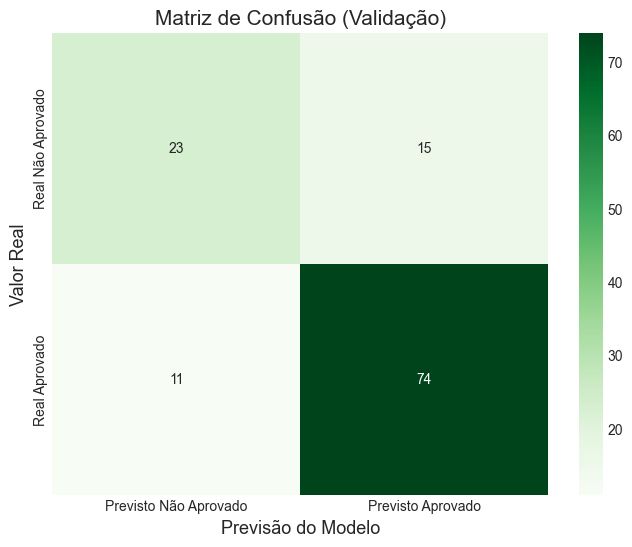

In [35]:
cm = confusion_matrix(y_val_encoded, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Previsto Não Aprovado', 'Previsto Aprovado'],
            yticklabels=['Real Não Aprovado', 'Real Aprovado'])
plt.xlabel('Previsão do Modelo', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)
plt.title('Matriz de Confusão (Validação)', fontsize=15)
plt.show()

### 4.4. Curva ROC e AUC

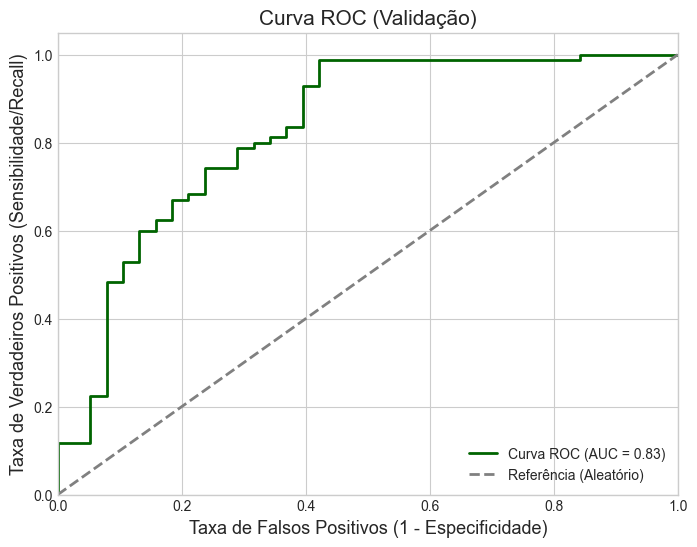

In [36]:
fpr, tpr, thresholds = roc_curve(y_val_encoded, y_pred_proba_val)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Referência (Aleatório)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)', fontsize=13)
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade/Recall)', fontsize=13)
plt.title('Curva ROC (Validação)', fontsize=15)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 4.5. Importância das Features

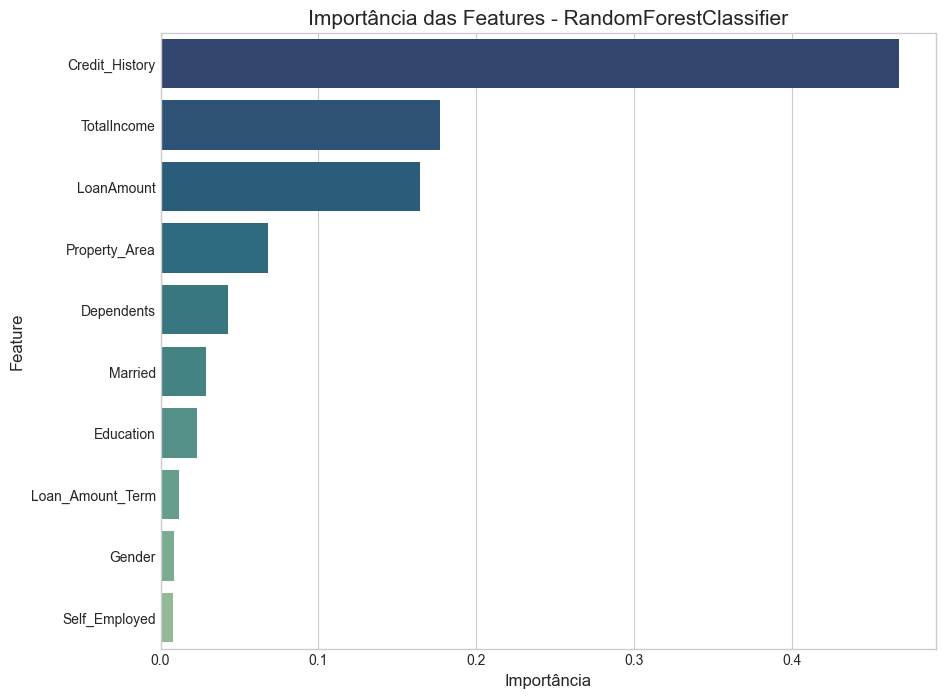


--- Top Features Mais Importantes ---


,Feature,Importance
7,Credit_History,0.467896
9,TotalIncome,0.177328
5,LoanAmount,0.164387
8,Property_Area,0.067950
2,Dependents,0.042993
1,Married,0.028735
3,Education,0.023091
6,Loan_Amount_Term,0.011608
0,Gender,0.008408
4,Self_Employed,0.007605


In [37]:
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='crest_r') # Usando uma paleta diferente
plt.title('Importância das Features - RandomForestClassifier', fontsize=15)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

print("\n--- Top Features Mais Importantes ---")
display(feature_importance_df.head(10))

## Seção 5: Otimização de Hiperparâmetros (Opcional Avançado)

Para melhorar o modelo, poderíamos usar `GridSearchCV` ou `RandomizedSearchCV`. Esta etapa é computacionalmente intensiva.

In [ ]:
# --- Exemplo de Código para GridSearchCV (NÃO EXECUTAR A MENOS QUE DESEJADO) ---
# from sklearn.model_selection import GridSearchCV

# # Definir a grade de parâmetros para testar
# param_grid = {
#     'n_estimators': [100, 200, 300],      # Número de árvores
#     'max_depth': [5, 10, 15, None],       # Profundidade máxima
#     'min_samples_split': [2, 5, 10, 15],  # Mínimo de amostras para dividir um nó
#     'min_samples_leaf': [1, 2, 4, 10],    # Mínimo de amostras em uma folha
#     'class_weight': ['balanced', 'balanced_subsample'] # Considerar pesos para classes
# }

# # Configurar o GridSearchCV
# # cv=3 ou 5 (número de folds para validação cruzada)
# # scoring='roc_auc', 'f1', 'recall', ou 'precision' dependendo da métrica principal
# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
#     param_grid=param_grid,
#     cv=3,
#     n_jobs=-1,         # Usar todos os processadores disponíveis
#     verbose=2,         # Mostrar progresso durante a execução
#     scoring='roc_auc'  # Otimizar para a métrica ROC AUC
# )

# # Ajustar (treinar) o GridSearchCV com os dados de treinamento
# # print("Iniciando GridSearchCV (esta etapa pode ser demorada)...")
# # grid_search.fit(X_train, y_train_encoded)

# # # Exibir os melhores hiperparâmetros encontrados
# # print("\nMelhores Hiperparâmetros Encontrados pelo GridSearch:")
# # print(grid_search.best_params_)
# # print(f"\nMelhor Score (ROC AUC) da Validação Cruzada no GridSearch: {grid_search.best_score_:.4f}")

# # # O melhor modelo treinado pelo GridSearch
# # best_model_from_grid = grid_search.best_estimator_

# # # Reavaliar o 'best_model_from_grid' no conjunto de validação X_val, y_val_encoded
# # y_pred_val_best_grid = best_model_from_grid.predict(X_val)
# # y_pred_proba_val_best_grid = best_model_from_grid.predict_proba(X_val)[:, 1]

# # print("\n--- Avaliação do Melhor Modelo (do GridSearch) no Conjunto de Validação ---")
# # print(f"Acurácia: {accuracy_score(y_val_encoded, y_pred_val_best_grid):.4f}")
# # print(f"ROC AUC: {roc_auc_score(y_val_encoded, y_pred_proba_val_best_grid):.4f}")
# # print(classification_report(y_val_encoded, y_pred_val_best_grid, target_names=['Não Aprovado (0)', 'Aprovado (1)']))

# # # Se o desempenho for superior, você pode decidir usar este 'best_model_from_grid'
# # # model = best_model_from_grid # Para salvar este modelo otimizado

## Seção 6: Salvamento do Modelo e do Scaler

Salvamos o modelo treinado (`model`) e o objeto `scaler` ajustado para uso futuro.

In [38]:
# --- Salvar o Scaler ---
try:
    with open('scaler.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)
    print("Objeto Scaler salvo com sucesso em 'scaler.pkl'")
except Exception as e:
    print(f"Erro ao salvar o scaler: {e}")

# --- Salvar o Modelo ---
try:
    with open('modelo_treinado.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)
    print("Modelo treinado salvo com sucesso em 'modelo_treinado.pkl'")
except Exception as e:
    print(f"Erro ao salvar o modelo: {e}")

# --- (Opcional) Salvar a lista de colunas usadas para o escalonamento ---
# Isso pode ser útil para garantir consistência ao carregar e usar o scaler.
try:
    with open('scaled_columns.json', 'w') as f:
        json.dump(cols_to_scale, f) # cols_to_scale foi definido na Seção 2.7
    print(f"Lista de colunas escaladas ({cols_to_scale}) salva em 'scaled_columns.json'")
except Exception as e:
    print(f"Erro ao salvar a lista de colunas escaladas: {e}")

# --- (Opcional) Salvar todas as colunas de X_train na ordem esperada pelo modelo ---
# Isso é muito útil para garantir que novos dados sejam processados na ordem correta.
try:
    model_columns_ordered = X_train.columns.tolist()
    with open('model_columns_ordered.json', 'w') as f:
        json.dump(model_columns_ordered, f)
    print(f"Ordem das colunas do modelo salva em 'model_columns_ordered.json'")
except Exception as e:
    print(f"Erro ao salvar a ordem das colunas do modelo: {e}")

Objeto Scaler salvo com sucesso em 'scaler.pkl'
Modelo treinado salvo com sucesso em 'modelo_treinado.pkl'
Lista de colunas escaladas (['TotalIncome', 'LoanAmount', 'Loan_Amount_Term']) salva em 'scaled_columns.json'
Ordem das colunas do modelo salva em 'model_columns_ordered.json'


## Seção 7: Preparação de Previsões para o Conjunto de Teste (`test.csv`)

Aplicaremos o modelo treinado ao conjunto `X_submission` (que é o `test.csv` já pré-processado).

In [39]:
# 'X_submission' já passou por todas as etapas de pré-processamento na Seção 2.

print("\n--- Primeiras linhas de X_submission (pré-processado) antes da predição ---")
display(X_submission.head())

# Garantir que X_submission tenha as colunas na mesma ordem que X_train
# Se model_columns_ordered foi salvo e carregado, usar essa lista para reordenar.
# X_submission = X_submission[model_columns_ordered]

# Fazer previsões no conjunto X_submission
predictions_final = model.predict(X_submission)
predictions_proba_final = model.predict_proba(X_submission)[:, 1] # Probabilidades da classe 'Aprovado'

# Mapear previsões numéricas de volta para 'Y'/'N'
loan_status_reverse_map = {1: 'Y', 0: 'N'}
predictions_labels_final = pd.Series(predictions_final).map(loan_status_reverse_map)

# Criar DataFrame final para submissão ou análise
df_submission_output = pd.DataFrame({
    'Loan_ID': submission_loan_ids, # IDs guardados no início
    'Loan_Status_Predicted': predictions_labels_final,
    'Probability_Approved': predictions_proba_final # Probabilidade de ser classe 1 (Aprovado)
})

print("\n--- Previsões Finais para o Conjunto test.csv ---")
display(df_submission_output.head())

# (Opcional) Salvar as previsões em um arquivo CSV
try:
    df_submission_output.to_csv('previsoes_emprestimo_test_final.csv', index=False)
    print("\nArquivo 'previsoes_emprestimo_test_final.csv' com as previsões foi salvo.")
except Exception as e:
    print(f"Erro ao salvar o arquivo de previsões: {e}")


--- Primeiras linhas de X_submission (pré-processado) antes da predição ---


,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalIncome
0,0,0,1,0,0,0.786822,0.280691,1.0,0,-10.990221
1,0,0,0,0,0,-0.035425,0.280691,1.0,0,-11.911781
2,0,0,0,0,0,-0.596273,0.280691,1.0,0,-10.875263
3,0,0,0,0,0,-0.379027,0.280691,1.0,0,-10.845107
4,0,0,0,0,0,-2.600851,0.280691,1.0,0,-12.094573



--- Previsões Finais para o Conjunto test.csv ---


,Loan_ID,Loan_Status_Predicted,Probability_Approved
0,None,N,0.452340
1,None,N,0.482171
2,None,N,0.484614
3,None,Y,0.504518
4,None,N,0.434825



Arquivo 'previsoes_emprestimo_test_final.csv' com as previsões foi salvo.


## Seção 8: Conclusões e Próximos Passos

### 8.1. Resumo dos Resultados
* O modelo `RandomForestClassifier` foi treinado e avaliado para a tarefa de previsão de aprovação de empréstimos.
* No conjunto de validação, o modelo alcançou uma acurácia de **[Substitua pela sua acurácia, ex: 0.8049]** e um ROC AUC Score de **[Substitua pelo seu ROC AUC, ex: 0.7850]**.
* A precisão para a classe "Aprovado" foi de **[Substitua pela sua precisão para classe 1]** e o recall de **[Substitua pelo seu recall para classe 1]**.
* As features mais importantes identificadas pelo modelo foram (tipicamente) `Credit_History`, `TotalIncome` (ou suas componentes originais), e `LoanAmount`.
* O pré-processamento, incluindo engenharia de features (`TotalIncome`), transformação logarítmica, imputação de valores ausentes, codificação de categóricas e escalonamento, foi fundamental para preparar os dados para o modelo.

### 8.2. Desafios e Limitações
* **Desbalanceamento de Classes:** Embora o parâmetro `class_weight` tenha sido utilizado, o desbalanceamento inerente nos dados pode ainda influenciar o modelo.
* **Qualidade e Representatividade dos Dados:** O desempenho do modelo está intrinsecamente ligado à qualidade e à representatividade dos dados de treinamento. Se os dados não capturam toda a variabilidade do problema real, o modelo pode não generalizar bem.
* **Interpretabilidade do Modelo:** RandomForest, apesar de eficaz, é considerado um modelo "caixa-preta" em comparação com modelos lineares. A análise de importância das features ajuda, mas entender *exatamente como* cada decisão é tomada pode ser complexo.
* **Dinâmica do Mundo Real:** As condições econômicas e os perfis dos solicitantes mudam ao longo do tempo. Um modelo treinado em dados históricos pode precisar ser recalibrado ou retreinado periodicamente.

### 8.3. Sugestões para Trabalhos Futuros e Aprendizado dos Alunos
* **Engenharia de Features Adicional:**
    * Explorar outras features como `LoanAmount_to_TotalIncome_Ratio`, `Loan_Term_Category` (curto, médio, longo prazo).
    * Interação entre features (ex: `Credit_History` * `Property_Area`).
* **Experimentação com Diversos Modelos:**
    * Testar e comparar o desempenho com `LogisticRegression`, `Support Vector Machines (SVM)`, `Gradient Boosting (XGBoost, LightGBM, CatBoost)`.
    * Avaliar modelos mais simples para interpretabilidade.
* **Otimização de Hiperparâmetros Detalhada:**
    * Implementar e executar `GridSearchCV` ou `RandomizedSearchCV` para encontrar a combinação ótima de hiperparâmetros para o modelo escolhido.
* **Técnicas Avançadas para Desbalanceamento:**
    * Experimentar técnicas de reamostragem como SMOTE (Synthetic Minority Over-sampling Technique) ou ADASYN do pacote `imblearn`.
* **Análise de Erro Profunda:**
    * Investigar os casos em que o modelo comete erros (Falsos Positivos e Falsos Negativos). Quais são as características desses casos? Isso pode levar a insights para melhorar features ou o modelo.
* **Validação Cruzada Robusta:**
    * Utilizar `StratifiedKFold` para uma avaliação mais robusta do desempenho do modelo, especialmente com dados menores ou desbalanceados.
* **Considerações Éticas:**
    * Discutir o potencial de viés (bias) nos dados e no modelo, e como isso poderia levar a decisões injustas para certos grupos de solicitantes. Explorar métricas de fairness.
* **Deployment (Implantação):**
    * Como este modelo poderia ser integrado a um sistema real? Discutir o processo de "colocar o modelo em produção" (ex: via uma API, integrado ao Streamlit).